# Práctica 4 de IA

# 3. Procesamiento de texto y datos no balanceados (4,5 puntos)

In [1]:
import pandas as pd

df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
pd.set_option('display.max_colwidth', None)
df.head(2)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
2,1,A series of escapades demonstrating the adage that what is good for the goose,2


Este conjunto de datos que usaremos ahora permite aprender el sentimiento del texto a partir de frases etiquetadas.
Las etiquetas para los sentimientos son:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

Más información [aquí](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).


A lo largo de este ejercicio veremos distintas formas de procesar el texto y de equilibrar las clases a aprender.

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

**Modelos básicos**

Vamos a comenzar con una concatenación (*pipe*) de modelos muy básicos y analizaremos si tienen algún problema.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

count_vectorizer = CountVectorizer(max_features=1000)
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
pipe = make_pipeline(count_vectorizer,decision_tree)

In [4]:
from sklearn.metrics import accuracy_score

def get_accuracy(pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test),3)

In [5]:
get_accuracy(pipe)

0.515

Veamos qué clases se están prediciendo de verdad

In [6]:
# Etiquetas de entrenamiento
round(pd.Series(y_train).value_counts(normalize=True),2)

2    0.51
3    0.21
1    0.17
4    0.06
0    0.04
Name: Sentiment, dtype: float64

In [7]:
# Clases en predicción
y_pred = pipe.predict(X_test)
round(pd.Series(y_pred).value_counts(normalize=True),2)

2    0.97
3    0.03
dtype: float64

Es decir: al ser un problema no balanceado, la predicción está claramente sesgada hacia una de las clases.

Esto se puede ver también analizando la **matriz de confusión**

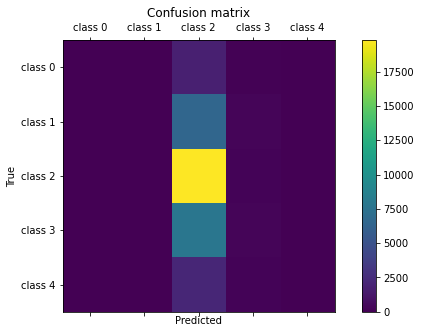

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(pipe):
    ticks = np.unique(y_test)
    labels = [('class '+ str(tick)) for tick in ticks]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(pipe)

## Cambio de modelos y procesamiento de los datos

Analiza si algún otro modelo de los vistos en ejercicios anteriores evita este problema de las clases desbalanceadas.

Por ejemplo, en la celda siguiente se cambia el árbol de decisión por un KNN.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
pipe_knn = make_pipeline(count_vectorizer,knn)
get_accuracy(pipe_knn)

0.564

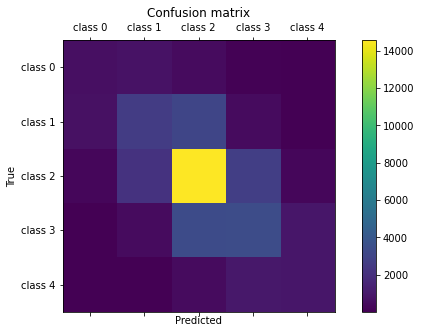

In [22]:
plot_confusion_matrix(pipe_knn)

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
pipe_knn = make_pipeline(count_vectorizer,knn)
get_accuracy(pipe_knn)

0.572

Ejecutamos varias pruebas cambiando el valor del número de vecinos la tasa de acierto subía y a partir de 5 empezaba a bajar, por lo que usamos 5 vecinos al tener la mayor tasa de aciertos.

[n | Tasa de aciertos]
[1 | 0.564]
[3 | 0.562]
[5 | 0.572]
[7 | 0.57]
[9 | 0.566]
[11 | 0.569]
[13 | 0.556]

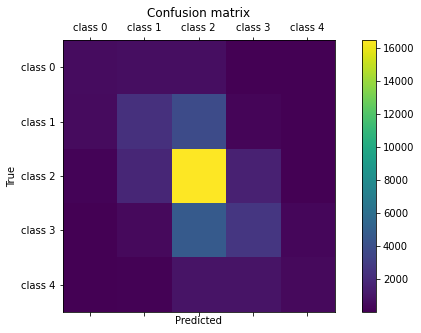

In [20]:
plot_confusion_matrix(pipe_knn)

Observamos que con k-vecinos próximos se "reparte" la confusión entre las clases vecinas, de manera que no se tiende a clasificar siempre como clase 2 como sucedía antes. Es importante resaltar que la tasa de acierto no llega al 60% lo que a nuestro padecer es un valor bajo, producido en gran medida por la complejidad del problema y el banco de pruebas repleto de ejemplos de clase 2. Aun así, hay que destacar que se ha mejorado del 51,5% al 57,2% usando k-vecinos, lo cual es una mejora considerable.

También observamos que al aumentar el número de vecinos aumenta la tendencia a clasificar como clase 2, por lo que si queremos evitar el desbalanceo de clases no nos sirve aumentar el número de vecinos.

### Explora varios modelos y responde:

* ¿Con qué modelo se obtienen mejores resultados?
* ¿Hay algún parámetro de los modelos que sea particularmente efectivo en evitar el desbalanceo?

Nota: incluye tantas celdas como precises para enseñar el código que has usado para responder a estas preguntas.

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
pipe_tree = make_pipeline(count_vectorizer,clf)
get_accuracy(pipe_tree)

0.523

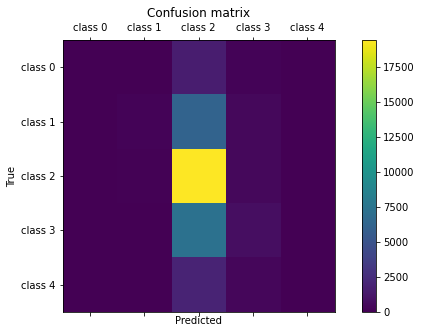

In [14]:
plot_confusion_matrix(pipe_tree)

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=150)
pipe_tree = make_pipeline(count_vectorizer,clf)
get_accuracy(pipe_tree)

0.597

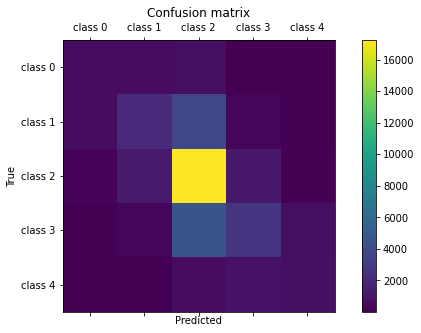

In [32]:
plot_confusion_matrix(pipe_tree)

Vemos que el resultado con decision tree con poca profundidad es como el original, tiende a clasificar como clase 2 a la mayoría de ejemplos. Además la tasa de acierto es incluso menor que la de k-vecinos próximos.

Pero si aumentamos mucho la profundidad máxima el resultado mejora y balancea mejor las clases, en particular probando hemos llegado a la conclución de que mejora hasta profundidad en torno a 150 y a partir de ese valor empieza a perder tasa de acierto a causa del overfitting.

En particular con 150 vecinos obtenemos una tasa de acierto de casi el 60%, lo cual mejora la tasa de ciertos en casi un 9% en comparación con el original.

In [16]:
from sklearn.neural_network import MLPClassifier

nneurons=6
nlayers=3
tupla = tuple([nneurons]*nlayers)
clf = MLPClassifier(hidden_layer_sizes=tupla, max_iter=1000, alpha=0)
pipe_neu = make_pipeline(count_vectorizer,clf)
get_accuracy(pipe_neu)

0.593

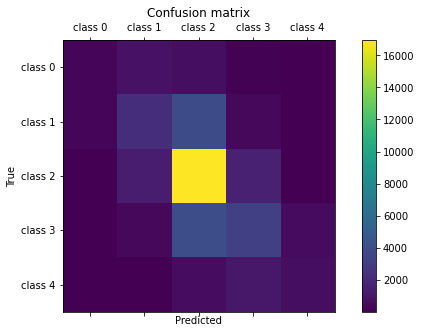

In [16]:
plot_confusion_matrix(pipe_neu)

Vemos que con la red neuronal obtenemos la mejor tasa de acierto, aún así sigue siendo una tasa bastante pobre posiblemente debido a que en la base de datos que se nos proporciona la inmensa mayoría de ejemplos son de la clase 2 y, al ser un problema tan cómplicado (incluso para seres humanos), puede haber pocos ejemplos del resto de clases para que la red neuronal aprenda a predecir las clases.

Aun así obtenemos una tasa de acierto de casi el 60%, lo cual mejora la tasa de ciertos en casi un 9% en comparación con el original.

In [63]:
from sklearn.neural_network import MLPClassifier

nneurons=10
nlayers=6
tupla = tuple([nneurons]*nlayers)
clf = MLPClassifier(hidden_layer_sizes=tupla, max_iter=1000, alpha=0)
pipe_neu = make_pipeline(count_vectorizer,clf)
get_accuracy(pipe_neu)

0.596

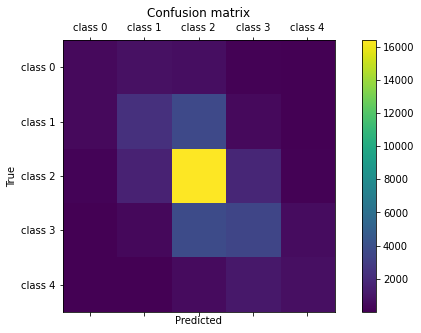

In [18]:
plot_confusion_matrix(pipe_neu)

Hemos probado a aumentar el número de neuronas y de capas y el resultado ha mejorado ligeramente, pero suponemos que estamos haciendo overfitting. Aún así no estamos contentos con los resultados.

### Procesamiento de los datos

El primer paso que se usó en el *pipe* anterior es muy simple: sólo cuenta cuántas veces aparece cada término. Además, se ha limitado a un máximo de 1000 dimensiones. Prueba otras formas de procesar el texto y discute las diferencias. 

Como ejemplo, en la celda siguiente se usa un método que considera la frecuencia de los términos ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)). La documentación muestra que permite varias configuraciones (eliminar acentos, pasar a minúsculas, realizar otras transformaciones más complejas, quitar palabras comunes, etc.).

0.605


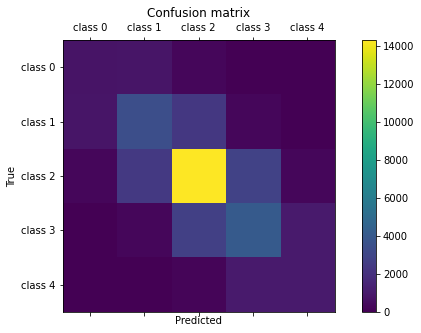

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

0.606


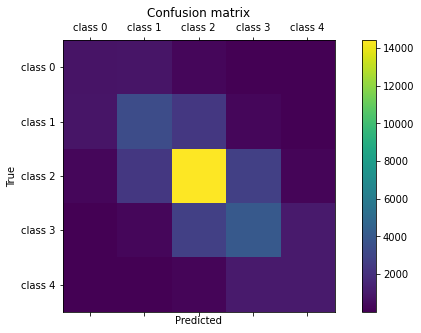

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Realiza pruebas con varios clasificadores y configuraciones para el procesamiento de texto y contesta:

* De acuerdo con tus experimentos, ¿afecta más cambiar el clasificador o cómo se procesa el texto?
* ¿Has encontrado algún tipo de procesamiento que siempre mejore los resultados? ¿En qué hipótesis te has basado para probarlo?

NOTA: Hemos añadido los imports en todas las celdas para poder realizar las ejecuciones de manera independiente y no tener que volver a ejecutar las celdas anteriores por el alto coste computacional.

0.581


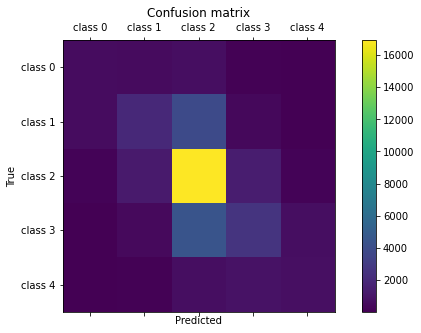

In [24]:
# incluye aquí código sobre este apartado
from sklearn.feature_extraction.text import TfidfVectorizer
tree = DecisionTreeClassifier(max_depth=150)

tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, tree)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

0.601


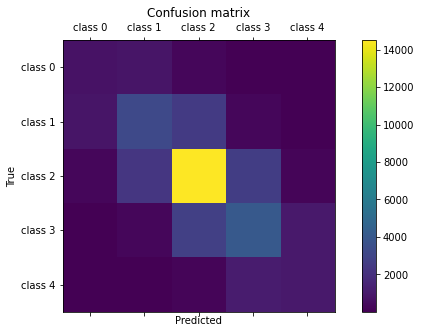

In [23]:
# incluye aquí código sobre este apartado
from sklearn.feature_extraction.text import TfidfVectorizer
neu = MLPClassifier(hidden_layer_sizes=tupla, max_iter=1000, alpha=0)

tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, neu)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Vemos que cambiando el clasificador los resultados son muy parecidos, no obtenemos ninguna mejora destacable e incluso perdemos tasa de aciertos.

Vamos a probar a cambiar el modo de procesar los datos antes de clasificarlos. Para ello empezamos probando a quitar las palabras más frecuentes que no aportan nada de sentimientos a las frases como son 'A', 'The'... Para ello nos hemos definido dos funciones que nos sirven para sacar la frecuencia mínima de una lista de palabras y así poder quitarlas todas con el parámetro max_df de TfidfVectorizer.

In [14]:
# pd.read_csv?

In [33]:
def frecuencia_df(w):
    frecuencia=0
    for valor in df.values:
        for word in valor[1].split():
            if word==w or word==w.lower():
                frecuencia+=1
    return frecuencia

In [42]:
def less_frec(L): 
    min_frec=-1
    for word in L:
        frec=frecuencia_df(word)
        if frec<min_frec or min_frec<0:
            min_frec=frec
    return min_frec

In [50]:
min_frec=less_frec(['A','The','Of','By','Be','To','And','In','That','Have','I'])
print(min_frec)
num_words=0
for valor in df.values:
    num_words+=len(valor[1].split())
print(num_words)
print(min_frec/num_words)
m=min_frec/num_words

1768
1124157
0.001572734057609391


0.547


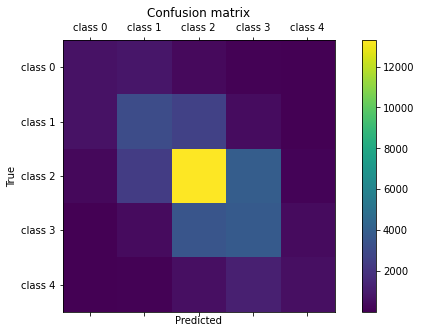

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=m)
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

En un primer intento metimos demasiadas palabras y la tasa de aciertos bajo. A continuación probamos otra lista de palabras que nos dio una mejora significativa.

In [56]:
min_frec=less_frec(['A','The','Of','That','And'])#,'To','Be','In','That','Have','I'])
print(min_frec)
num_words=0
for valor in df.values:
    num_words+=len(valor[1].split())
print(num_words)
print(min_frec/num_words)
m=min_frec/num_words

12327
1124157
0.010965550185605747


0.614


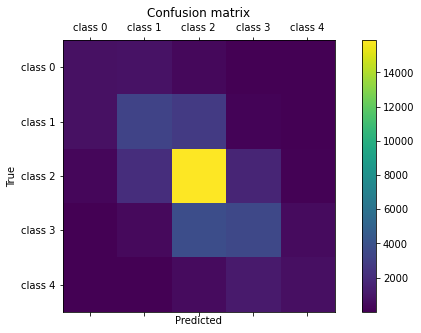

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=m)
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Si recordamos que venimos de una tasa de aciertos del 0.605 con knn tenemos una mejora del 0,9% de la tasa de aciertos, que aunque no es gran cosa, es mejor que las obtenidas haciendo numerosas pruebas anteriormente cambiando los clasificadores.

0.619


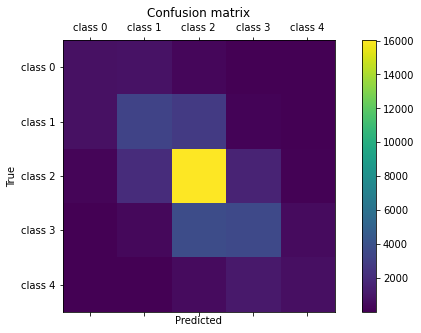

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

También hemos conseguido grandes mejoras con el argumento sublinear_tf (la mejora es del 1,4%), así que ahora probamos a combinar ambas mejoras.

0.614


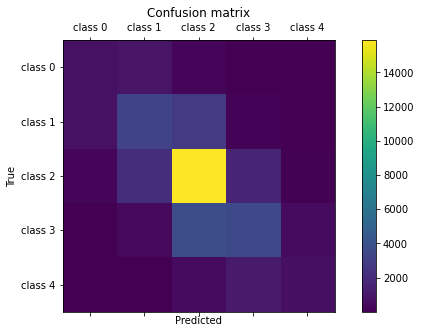

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True,max_df=m)
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

No todo podía ser tan bonito, combinando ambas mejoras hemos perdido tasa de aciertos. Aun así es mayor que la original.

0.61


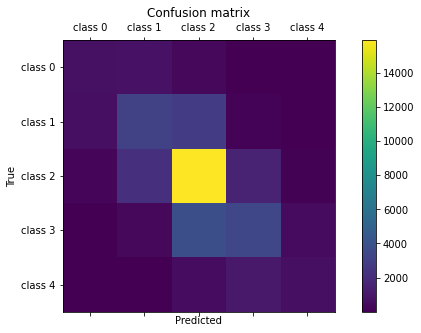

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

También hemos conseguido grandes mejoras con el argumento stop_words (la mejora es del 0,6%), así que ahora probamos a combinar ambas mejoras.

0.609


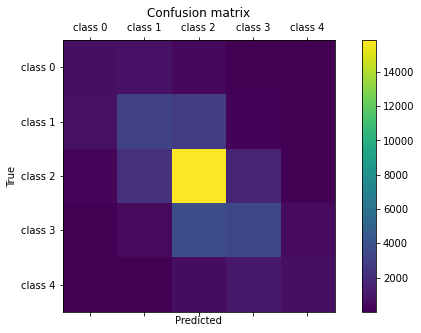

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=m)
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Al igual que antes, al combinar ambos métodos empeoramos la tasa de acierto.

0.568


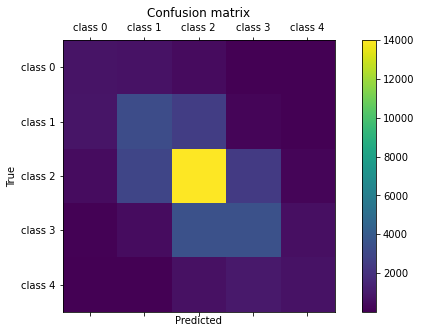

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=m, norm='l1')
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

0.567


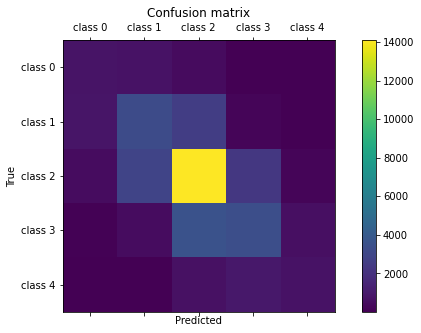

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(norm='l1')
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

0.559


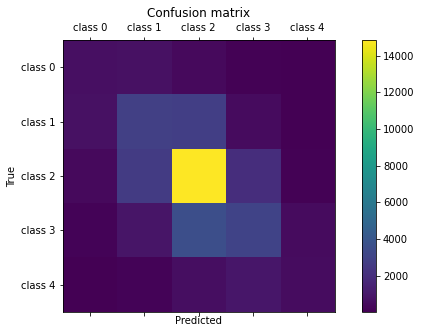

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb')
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Hemos tratado de probar otras maneras de procesar el texto pero no hemos conseguido mejoras, sino pérdidas de la tasa de aciertos. Como resumen la mayor mejora la hemos obtenido con max_df quitando unas pocas palabras muy comunes.

Vamos a probar a combinar la mejora del procesamiento con las frecuencias y a usar redes neuronales.

In [62]:
min_frec=less_frec(['A','The','Of','That','And'])#,'To','Be','In','That','Have','I'])
print(min_frec)
num_words=0
for valor in df.values:
    num_words+=len(valor[1].split())
print(num_words)
print(min_frec/num_words)
m=min_frec/num_words

12327
1124157
0.010965550185605747


0.607


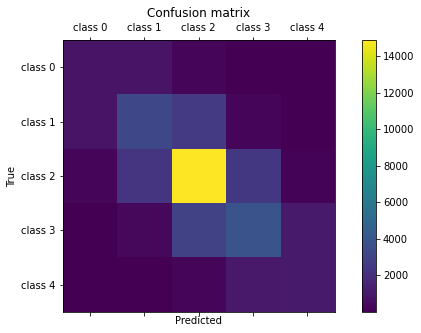

In [67]:
# incluye aquí código sobre este apartado
from sklearn.feature_extraction.text import TfidfVectorizer
neu = MLPClassifier(hidden_layer_sizes=tupla, max_iter=1000, alpha=0)

tfidf_vectorizer = TfidfVectorizer(max_df=m)
pipe_tfidf = make_pipeline(tfidf_vectorizer, neu)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

La combinación de max_df con redes neuronales ha mejorado el rendimiento comparado a las redes neuronales pero ha empeorado el comparado con k-vecinos.

Como resumen:
* Generalmente los resultados mejoran más cambiando el modo de procesar el texto que cambiando el clasificador. Esto es lógico pues un mal procesamiento del texto devuelve una información confusa y con ruido difícil de clasificar. Nosotros hemos obtenido los mejores resultados eliminando unas pocas palabras muy frecuentes (eliminar demasiadas empeora los resultados). Además de esto hemos conseguido mejoras significativas cambiando los parámetros sublinear_tf y stop_words. Como decíamos antes estas mejoras son superiores a las obtenidas cambiando solo los clasificadores por árboles lógicos, redes neuronales y k-vecinos y cambiando sus hiperparámetros. De estos clasificadores el mejor resultado ha sido obtenido con k-vecinos.
* Además, hay más parámetros que no hemos probado porque no parecen que puedan aportar una mejora y, debido al coste computacional alto, hemos preferido centrarnos solo en los que considerabamos relevantes. Este coste computacional tamnbién ha provocado que no podamos probar todas las combinaciones de los parámetros que si han mejorado la tasa de aciertos.